Generating noise power spectra...
Loading power spectra...

=== Simulation 43: A_s=2.1, r=0.006 ===


/home/nisl/.local/lib/python3.9/site-packages/lenspyx/utils_hp.py:91: RuntimeWarning: invalid value encountered in sqrt
  almxfl(alm, np.sqrt(cl[:lmax+1] * 0.5), mmax, True)


alm2lenmap: using 86 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.678997] (66.7%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.055812] (5.5%)  
  build_angles                         :  [0:00:00.734857] (72.2%)  
  synthesis general (STANDARD)         :  [0:00:00.282529] (27.8%)  
  gclm2lenmap                          :  [0:00:01.017439] (100.0%)  
  Total                                :  [0:00:01.017653] d:h:m:s:mus
alm2lenmap_spin: using 86 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:00.587899] (49.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:00.051082] (4.3%)  
  build_angles                         :  [0:00:00.639023] (53.7%)  
  synthesis general (GRAD_ONLY)        :  [0:00:00.532786] (44.8%)  
  polrot (ducc)                        :  [0:00:00.017967] (1.5%)  
  gclm2lenmap                          :  [0:00:01.189829] (100.0%)  
  Total                                :  [0:00:01.189990] d:h:m:s:mus
alm2lenmap: using 86 nthreads
  bui

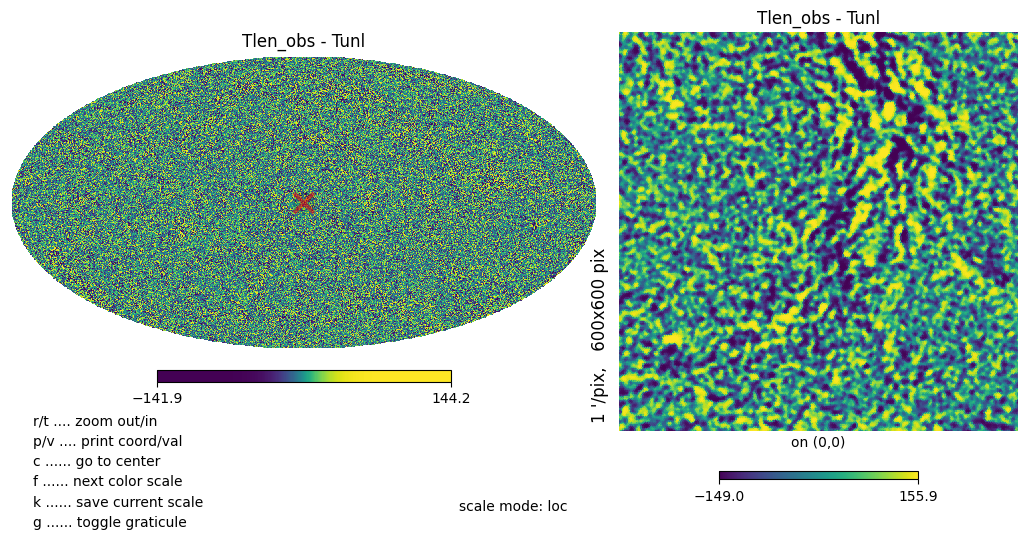

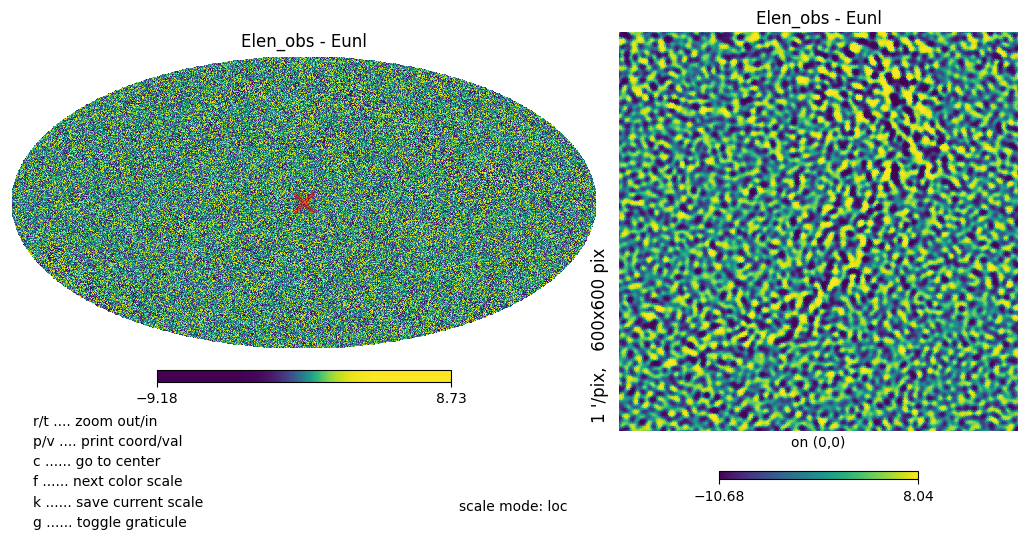

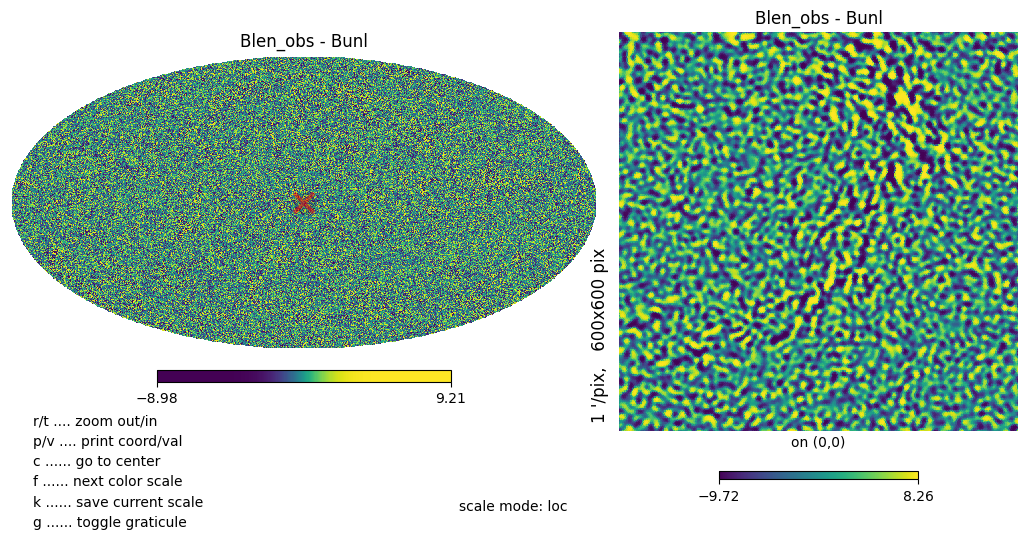

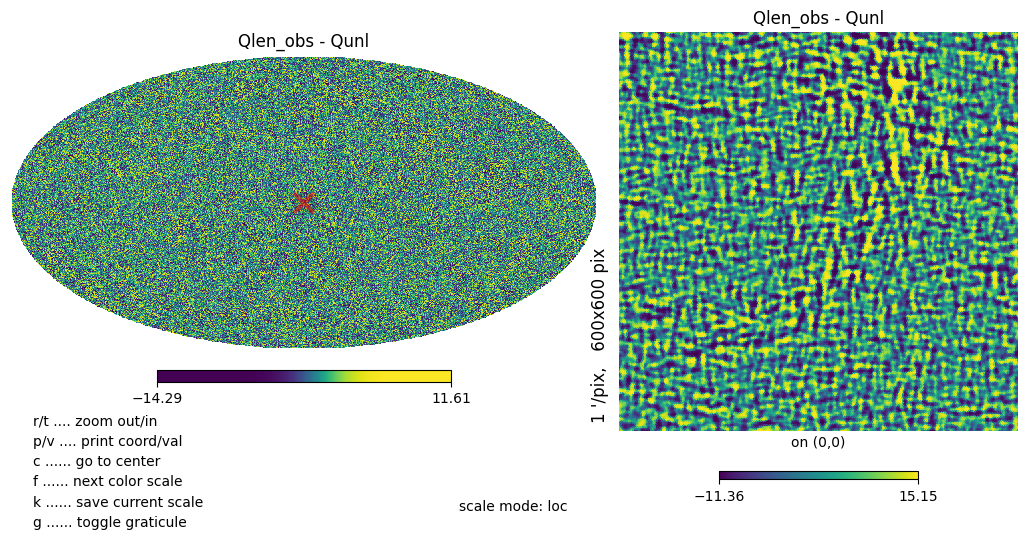

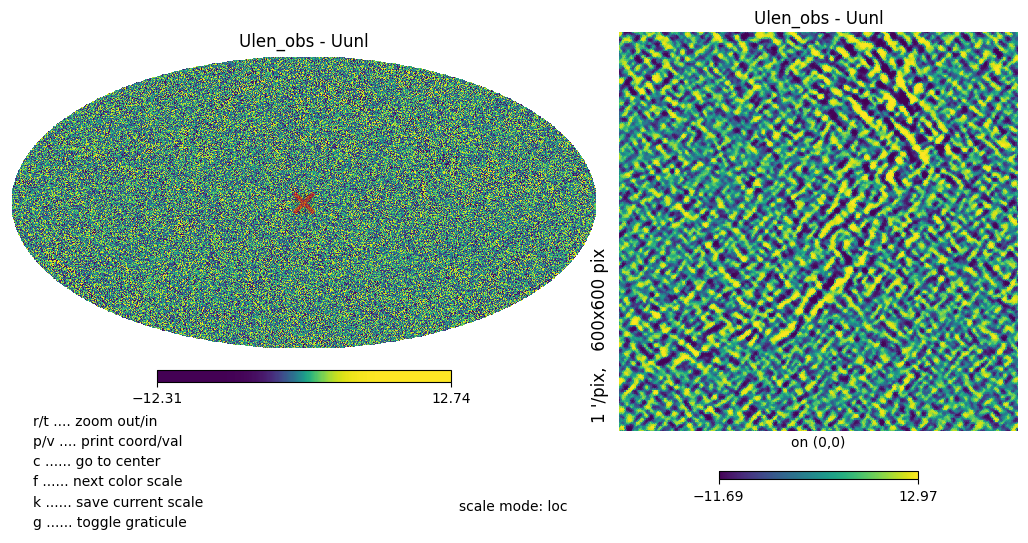

In [2]:
import os
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp
from lenspyx.utils import camb_clfile, get_ffp10_cls
from lenspyx.utils_hp import synalm, almxfl, alm2cl
from lenspyx import synfast
import matplotlib.pyplot as plt


def generate_noise_cls(ls, net, theta_arcmin=8.3):
    """
    Calculate noise power spectrum for a given sensitivity and beam
    
    Parameters:
    -----------
    ls : array_like
        Multipole values
    net : float
        Noise equivalent temperature in K
    theta_arcmin : float
        Beam FWHM in arcminutes
        
    Returns:
    --------
    noise_cl : array_like
        Noise power spectrum
    """
    theta_rad = theta_arcmin / 60.0 * np.pi / 180.0  # Convert to radians
    return net * net / np.exp(-ls * (ls + 1) * theta_rad * theta_rad / 8.0 / np.log(2))

def generate_noise_maps(nside, noise_T_cl, noise_E_cl, noise_B_cl, seed=None):
    """
    Generate noise maps for T, E, B modes
    
    Parameters:
    -----------
    nside : int
        HEALPix resolution parameter
    noise_T_cl, noise_E_cl, noise_B_cl : array_like
        Noise power spectra for T, E, B modes
    seed : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    noise_T_map, noise_E_map, noise_B_map : array_like
        Noise maps for T, E, B modes
    """
    if seed is not None:
        np.random.seed(seed)
    
    lmax = 3 * nside - 1
    
    # Generate T mode noise map
    noise_T_alm = hp.synalm(noise_T_cl, lmax=lmax, new=True)
    noise_T_map = hp.alm2map(noise_T_alm, nside=nside)
    
    # Generate E and B mode noise map
    noise_E_alm = hp.synalm(noise_E_cl, lmax=lmax, new=True)
    noise_B_alm = hp.synalm(noise_B_cl, lmax=lmax, new=True)

    noise_Q_map, noise_U_map = hp.alm2map_spin([noise_E_alm, noise_B_alm], 
                                                nside=nside, spin=2, lmax=lmax)
    
    return noise_T_map, noise_Q_map, noise_U_map

def to_eb(Qlen, Ulen, Qunl, Uunl, nside):
    """
    Convert Q, U polarization maps to E, B mode maps
    
    Parameters:
    -----------
    Qlen, Ulen : array_like
        Lensed Q and U polarization maps
    Qunl, Uunl : array_like  
        Unlensed Q and U polarization maps
    nside : int
        HEALPix resolution parameter
        
    Returns:
    --------
    Elen_map, Eunl_map, Blen_map, Bunl_map : array_like
        E and B mode maps for lensed and unlensed cases
    """
    
    print("Converting Q, U maps to E, B modes...")
    
    # Calculate lmax for spin transform
    lmax_spin = nside - 1
    
    alm_len_p2, alm_len_m2 = hp.map2alm_spin([Qlen, Ulen], spin=2, lmax=lmax_spin)
    Elen_alm = -(alm_len_p2 + alm_len_m2) / 2
    Blen_alm = 1j * (alm_len_p2 - alm_len_m2) / 2
    
    alm_unl_p2, alm_unl_m2 = hp.map2alm_spin([Qunl, Uunl], spin=2, lmax=lmax_spin)
    Eunl_alm = -(alm_unl_p2 + alm_unl_m2) / 2
    Bunl_alm = 1j * (alm_unl_p2 - alm_unl_m2) / 2
    
    Elen_map, Blen_map = hp.alm2map_spin([Elen_alm, Blen_alm], nside=nside, spin=2, lmax=lmax_spin)
    Eunl_map, Bunl_map = hp.alm2map_spin([Eunl_alm, Bunl_alm], nside=nside, spin=2, lmax=lmax_spin)
    
    return Elen_map, Blen_map, Eunl_map, Bunl_map


# Parameter settings
i = 0
As = [2.0, 2.1, 2.2][1:2]  # Amplitude of scalar perturbations (10^9 A_s)
rs = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01][5:6]  # Tensor-to-scalar ratio
linears = [2]
splt = int(len(As)*len(rs))

# Initialize storage lists
lenmaps = []
unlenmaps = []
lenmap_arrs = []
unlenmap_arrs = []

# Basic parameters
nside = 2048
lmax_len = 3000  # Desired lmax of the lensed field
dlmax = 1024     # lmax of unlensed fields is lmax + dlmax (buffer required for accurate lensing at lmax)
epsilon = 1e-6   # Target accuracy of the output maps

lmax_unl, mmax_unl = lmax_len + dlmax, lmax_len + dlmax
lmax_len, mmax_len = lmax_unl, mmax_unl





# Noise parameters
t_sec = 24*3600  # observation time in seconds
n_det = 1000   # number of detectors
beam_fwhm_arcmin = 8.3  # Beam FWHM in arcminutes
noise_T_sensitivity = 0.67/np.sqrt(n_det*t_sec)  # Temperature noise in uK
noise_E_sensitivity = 0.94/np.sqrt(n_det*t_sec)  # E-mode noise in uK
noise_B_sensitivity = 0.94/np.sqrt(n_det*t_sec) # B-mode noise in uK
beam_fwhm_rad = beam_fwhm_arcmin / 60.0 * np.pi / 180.0


# Generate noise power spectra
print("Generating noise power spectra...")
lmax_noise = 2*nside
ls = np.arange(lmax_noise + 1)
noise_T_cl = generate_noise_cls(ls, noise_T_sensitivity, beam_fwhm_arcmin)
noise_E_cl = generate_noise_cls(ls, noise_E_sensitivity, beam_fwhm_arcmin)
noise_B_cl = generate_noise_cls(ls, noise_B_sensitivity, beam_fwhm_arcmin)

# Initialize result storage
Tlens = []
Qlens = []
Ulens = []
Tunls = []
Qunls = []
Uunls = []

# Create output directory
output_dir = './map_data/'
os.makedirs(output_dir, exist_ok=True)

# Load power spectra from custom files
print("Loading power spectra...")

cls_path = '../Gen_Power_Spectrum/cls/'
simulation_counter = 42

for a in As:
    for r in rs:
        simulation_counter += 1
        print(f"\n=== Simulation {simulation_counter}: A_s={a}, r={r} ===")
        
        # Load custom power spectra files
        unlensCL = camb_clfile(os.path.join(cls_path, f'cls_As_{a}_r_{r}_lenspotentialCls.dat'))

        tlm_unl = synalm(unlensCL['tt'], lmax=lmax_unl, mmax=mmax_unl)
        elm_unl = synalm(unlensCL['ee'], lmax=lmax_unl, mmax=mmax_unl)
        blm_unl = synalm(unlensCL['bb'], lmax=lmax_unl, mmax=mmax_unl)

        plm = synalm(unlensCL['pp'], lmax=lmax_unl, mmax=mmax_unl)

        dlm = almxfl(plm, np.sqrt(np.arange(lmax_unl + 1, dtype=float) * np.arange(1, lmax_unl + 2)), None, False)

        geom_info = ('healpix', {'nside':nside}) # here we will use an Healpix grid with nside 2048
        geom = lenspyx.get_geom(geom_info)
        Tunl = lenspyx.alm2lenmap(tlm_unl, dlm*0, geometry=geom_info, verbose=1)
        Qunl, Uunl = lenspyx.alm2lenmap_spin(elm_unl, dlm*0, 2, geometry=geom_info, verbose=1)
        Tlen = lenspyx.alm2lenmap(tlm_unl, dlm, geometry=geom_info, verbose=1)
        Qlen, Ulen = lenspyx.alm2lenmap_spin(elm_unl, dlm, 2, geometry=geom_info, verbose=1)


        noise_T_map, noise_Q_map, noise_U_map = generate_noise_maps(nside, noise_T_cl, noise_E_cl, noise_B_cl)

        Tlen_obs = hp.smoothing(Tlen + noise_T_map, fwhm=beam_fwhm_rad)
        Qlen_obs = hp.smoothing(Qlen + noise_Q_map, fwhm=beam_fwhm_rad)
        Ulen_obs = hp.smoothing(Ulen + noise_U_map, fwhm=beam_fwhm_rad)

        Elen_obs, Blen_obs, Eunl, Bunl = to_eb(Qlen_obs, Ulen_obs, Qunl, Uunl, nside)
        
        
        
        print("Saving observational maps...")
        # hp.write_map(f"{output_dir}/Tlen_as_{a:.3f}_r_{r:.3f}.fits", Tlen_obs, overwrite=True)
        # hp.write_map(f"{output_dir}/Tunl_as_{a:.3f}_r_{r:.3f}.fits", Tunl, overwrite=True)
        # hp.write_map(f"{output_dir}/Elen_as_{a:.3f}_r_{r:.3f}.fits", Elen_obs, overwrite=True)
        # hp.write_map(f"{output_dir}/Eunl_as_{a:.3f}_r_{r:.3f}.fits", Eunl, overwrite=True)
        # hp.write_map(f"{output_dir}/Blen_as_{a:.3f}_r_{r:.3f}.fits", Blen_obs, overwrite=True)
        # hp.write_map(f"{output_dir}/Bunl_as_{a:.3f}_r_{r:.3f}.fits", Bunl, overwrite=True)

        
        # hp.write_map(f"{output_dir}/Qlen_as_{a:.3f}_r_{r:.3f}.fits", Qlen_obs, overwrite=True)
        # hp.write_map(f"{output_dir}/Ulen_as_{a:.3f}_r_{r:.3f}.fits", Ulen_obs, overwrite=True)
        # hp.write_map(f"{output_dir}/Qunl_as_{a:.3f}_r_{r:.3f}.fits", Qunl, overwrite=True)
        # hp.write_map(f"{output_dir}/Uunl_as_{a:.3f}_r_{r:.3f}.fits", Uunl, overwrite=True)
    

hp.mollzoom(Tlen_obs - Tunl, norm='hist', title='Tlen_obs - Tunl')
hp.mollzoom(Elen_obs - Eunl, norm='hist', title='Elen_obs - Eunl')
hp.mollzoom(Blen_obs - Bunl, norm='hist', title='Blen_obs - Bunl')

hp.mollzoom(Qlen_obs - Qunl, norm='hist', title='Qlen_obs - Qunl')
hp.mollzoom(Ulen_obs - Uunl, norm='hist', title='Ulen_obs - Uunl')

plt.show()